# Language Model Reports

Since my local machine does not have GPU support and thus can't perform many model training and evaluation tasks in a reasonable amount of time, I have created a script `evaluation.lua` in this repository which generates reports on a language model and serializes them in JSON. This notebook will consume these reports and explore them. It will also include some information about the models these reports were made for that is not included in the serialized report.

In [85]:
# load some requirements
import json
import matplotlib.pyplot as plt
with open('reports/unweightednoavg_one_layer_12.json', 'r') as f:
    first_report = json.loads(f.read())
with open('reports/unweightednoavg_7.json', 'r') as f:
    second_report = json.loads(f.read())
with open('reports/unweightednoavg_4.json', 'r') as f:
    third_report = json.loads(f.read())

# 25K Shallower, Broader Network Trained With Adam

I created a model with 1 LSTM layer, a dropout of 0.1, and a hidden size of 300. Here we can look at it's structure:

```
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> output]
  (1): nn.LookupTable
  (2): nn.LSTM(100 -> 512)
  (3): nn.Dropout(0.10000)
  (4): nn.DynamicView
  (5): nn.Linear(300 -> 25000)
  (6): nn.LogSoftMax
}
```

Notably, this one is a layer shallower and has a larger hidden size, with slightly reduced dropout. While it is not captured in the report, this model converged to it's final loss more quickly than the previous model. The use of adam also lead to considerably lower loss

### Perplexity on the Datasets

This model experienced a reduced perplexity across each of the datasets:


In [86]:
# print out the losses from the report
print 'Training set perplexity:', first_report['train_perplexity']
print 'Validation set perplexity:', first_report['valid_perplexity']
print 'Test set perplexity:', first_report['test_perplexity']

Training set perplexity: 143.271405408
Validation set perplexity: 228.638472902
Test set perplexity: 229.812204025


### Loss vs Epoch

Loss is charted vs. current epoch, with labels of the learning rate used at each epoch

<b> NOTE: In the first several series, loss is on the last training example. Current implementation calculates average loss, but this is not reflected in early series </b>

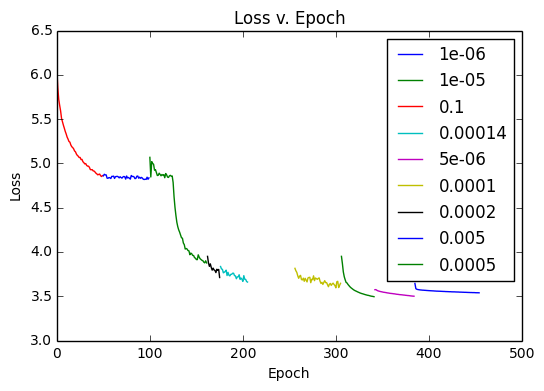

In [87]:
with open('logs/log_series.json', 'r') as f:
    logs = json.loads(f.read())
for k in logs.keys():
    plt.plot(logs[k][0], logs[k][1], label=str(k))
plt.title('Loss v. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [88]:
# function for turning report data into scatter plot
def scatterize_batch_loss(report_batch_loss):
    x = []
    y = []
    for i, v in enumerate(report_batch_loss):
        if i > 50:
            break # We'll only consider ones of length 50 and below to get a better view of the data in the chart.
        if isinstance(v, list):
            x.extend([i + 1 for j in v]) # same batch size for all losses in v
            y.extend([j for j in v])
        else:
            if v is not None:
                x.append(i)
                y.append(v)
    return x, y

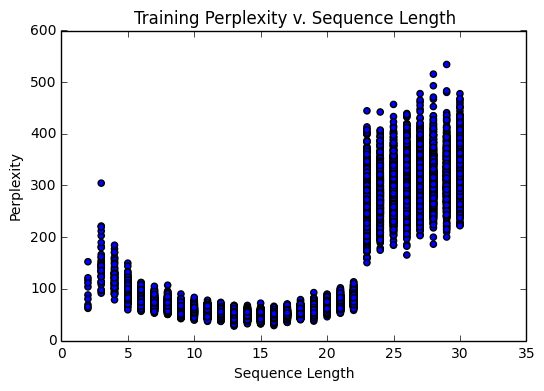

In [89]:
%matplotlib inline
x, y = scatterize_batch_loss(first_report['train_batch_perplexities'])
plt.scatter(x, y)
plt.title('Training Perplexity v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Perplexity')
plt.show()

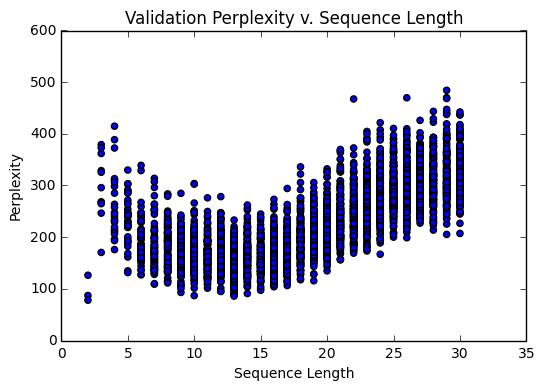

In [90]:
%matplotlib inline
x, y = scatterize_batch_loss(first_report['valid_batch_perplexities'])
plt.scatter(x, y)
plt.title('Validation Perplexity v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Perplexity')
plt.show()

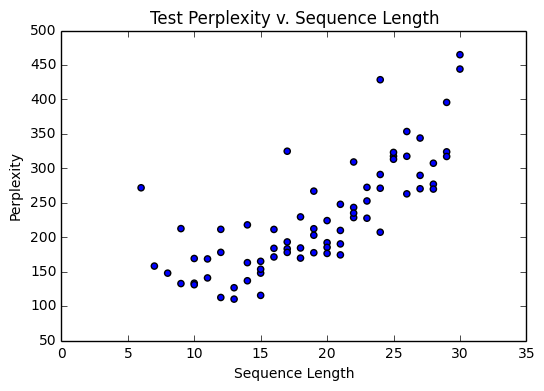

In [91]:
%matplotlib inline
x, y = scatterize_batch_loss(first_report['test_batch_perplexities'])
plt.scatter(x, y)
plt.title('Test Perplexity v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Perplexity')
plt.show()

Notably, this model has a loss below 6 for sequences that are ~10 words or less.

## Generation Samples

We can also look at examples of how it generates text. Below are side by side comparisons of the labels from the training/validation/test set and the sentence the model generated. A Special `<G>` token will be placed in the generated sequence to illustrate where the model's input ends and it's generation begins. I chose to look at only short sequences, as the models each have lower loss for these, and might stand a chance of answering correctly.

In [92]:
def print_sample(sample):
    seq = sample['generated'].split(' ')
    seq.insert(sample['supplied_length'] + 1, '<G>')
    gold = sample['gold'].split(' ')
    gold.insert(sample['supplied_length'], '<G>')
    print('Gend: ' + ' '.join(seq))
    print('True: ' + seq[1] + ' ' + ' '.join(gold) + '\n')
    

In [93]:
for sample in first_report['train_samples'][5:]:
    print_sample(sample)

Gend:  What 's the <G> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> ? </S>
True: What  's the <G> point . </S>

Gend:  My <G> <UNK> <UNK> , <UNK> , is a <UNK> <UNK> <UNK>
True: My  <G> <UNK> . </S>

Gend:  <UNK> said more consideration was needed when <UNK> crimes <G> were made to be released . </S>
True: <UNK>  said more consideration was needed when <UNK> crimes <G> . </S>

Gend:  Especially <G> unearthed 1913 , the <UNK> <UNK> and <UNK> . </S>
True: Especially  <G> for President Pelosi . </S>

Gend:  <UNK> is <G> the <UNK> of the <UNK> <UNK> , which is <UNK>
True: <UNK>  is <G> prized for its unprecedented resolution and accuracy . </S>



In [94]:
for sample in first_report['valid_samples'][0:5]:
    print_sample(sample)

Gend:  Lisa <UNK> owns an <UNK> center <G> of the <UNK> of the Year . </S>
True: Lisa  <UNK> owns an <UNK> center <G> . </S>

Gend:  Even <G> the assumption that the <UNK> is not the only way
True: Even  <G> your parents would probably agree with me . </S>

Gend:  You <G> <UNK> <UNK> , <UNK> , <UNK> , <UNK> , <UNK>
True: You  <G> have certainly turned things around since then . </S>

Gend:  Blake finished with 17 assists <G> and a <UNK> <UNK> in the <UNK> minute . </S>
True: Blake  finished with 17 assists <G> . </S>

Gend:  Gordon Brown has a different view . <G> </S>
True: Gordon  Brown has a different view . <G> </S>



In [95]:
for sample in first_report['test_samples'][0:5]:
    print_sample(sample)

Gend:  Even the basic <UNK> wasn 't being done <G> to the <UNK> <UNK> . </S>
True: Even  the basic <UNK> wasn 't being done <G> . </S>

Gend:  Its <G> <UNK> <UNK> , <UNK> <UNK> , <UNK> <UNK> , <UNK>
True: Its  <G> findings and those of other research reports follow . </S>

Gend:  And he kept his promise , " <UNK> <G> " and " <UNK> " is a <UNK> <UNK> .
True: And  he kept his promise , " <UNK> <G> recalls . </S>

Gend:  You have to have a soul for that . <G> </S>
True: You  have to have a soul for that . <G> </S>

Gend:  Eventually , it began to show . <G> </S>
True: Eventually  , it began to show . <G> </S>



### Conclusion

This model has lower loss and doesn't seem to make quite as many gibberish mistakes in generation (double periods, long strings of `<UNK>`, etc.) This is perhaps too small of a sample to make a real conclusion though. Like the previous model, it tends to favor abrupt endings, as it likely is being punished less for only getting a couple tokens wrong instead of a long sequence of wrong answers. It is also leaves an idea hanging, ending sentences with "the", etc.

# 25K Deeper, Thinner Network

I created a model with 2 LSTM layers, a dropout of 0.1, and a hidden size of 300. Here we can look at it's structure:

```
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> output]
  (1): nn.LookupTable
  (2): nn.LSTM(100 -> 300)
  (3): nn.Dropout(0.100000)
  (4): nn.LSTM(300 -> 300)
  (5): nn.Dropout(0.100000)
  (6): nn.DynamicView
  (7): nn.Linear(300 -> 25000)
  (8): nn.LogSoftMax
}
```

### Losses on the Datasets

I have created 3 datasets, built from the Google Billion Words data set. I trained on a version of the `train_small` data set with a reduced vocabulary of 25000, in batches of size 50, with a sequence length cut off of 30. I did not tune any hyper parameters with the validation set, but this could be future work. There is also a small test set.

In [96]:
# print out the losses from the report
print 'Training set loss:', second_report['train_perplexity']
print 'Validation set loss:', second_report['valid_perplexity']
print 'Test set loss:', second_report['test_perplexity']

Training set loss: 107.302684596
Validation set loss: 133.193710718
Test set loss: 132.899619827


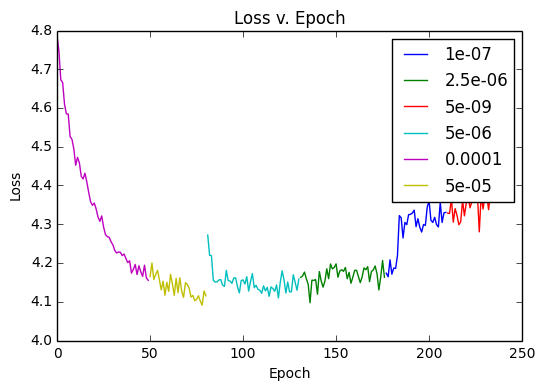

In [97]:
with open('logs/log_series_2_layer.json', 'r') as f:
    logs = json.loads(f.read())
for k in logs.keys():
    plt.plot(logs[k][0], logs[k][1], label=str(k))
plt.title('Loss v. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Loss Versus Sequence Length

We can examine the relationship between loss and sequence length. We can expect higher losses with increasing sequence length as more information must be remembered by the model as it generates, and the model is only trained on examples of sequence length 30 or less. We can generate a scatter plot of batch loss v. sequence length of batch (all batches are same size):

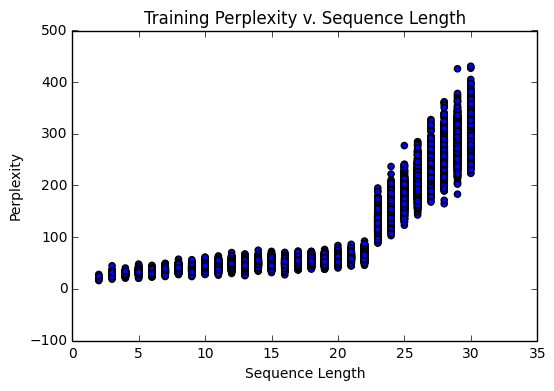

In [98]:
%matplotlib inline
x, y = scatterize_batch_loss(second_report['train_batch_perplexities'])
plt.scatter(x, y)
plt.title('Training Perplexity v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Perplexity')
plt.show()

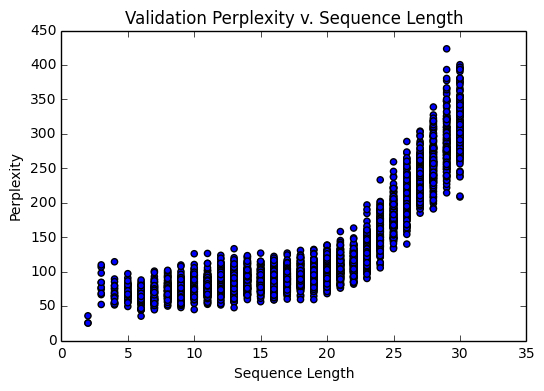

In [99]:
%matplotlib inline
x, y = scatterize_batch_loss(second_report['valid_batch_perplexities'])
plt.scatter(x, y)
plt.title('Validation Perplexity v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Perplexity')
plt.show()

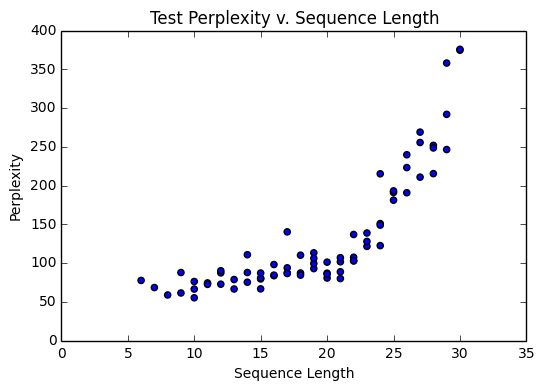

In [100]:
%matplotlib inline
x, y = scatterize_batch_loss(second_report['test_batch_perplexities'])
plt.scatter(x, y)
plt.title('Test Perplexity v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Perplexity')
plt.show()

## Generation Samples

We can also look at examples of how it generates text. Below are side by side comparisons of the labels from the training/validation/test set and the sentence the model generated. A Special `<G>` token will be placed in the generated sequence to illustrate where the model's input ends and it's generation begins.

#### Training Set Generation Examples

In [101]:
for sample in second_report['train_samples']:
    print_sample(sample)
    

Gend:  But the leaders of <G> the <UNK> are not <UNK> . </S>
True: But  the leaders of <G> the referendum movement are <UNK> . </S>

Gend:  It was truth . <G> </S>
True: It  was truth . <G> </S>

Gend:  Discovery 's launch <G> date is to be completed by the end of the
True: Discovery  's launch <G> remains targeted for February 3 . </S>

Gend:  Amtrak also failed to challenge <G> the <UNK> 's <UNK> , <UNK> <UNK> , <UNK> ,
True: Amtrak  also failed to challenge <G> the Oct . </S>

Gend:  Reading or <G> <UNK> , <UNK> , <UNK> , <UNK> , <UNK> ,
True: Reading  or <G> watching something becomes painful . </S>

Gend:  What little private enterprise exists is strictly limited . <G> </S>
True: What  little private enterprise exists is strictly limited . <G> </S>

Gend:  Peters was expected to appear in court Thursday <G> . </S>
True: Peters  was expected to appear in court Thursday <G> . </S>

Gend:  Quick . <G> </S>
True: Quick  . <G> </S>

Gend:  Iceland <G> 's <UNK> <UNK> <UNK> <UNK> <UNK> <

In [102]:
for sample in second_report['valid_samples'][0:5]:
    print_sample(sample)
    

Gend:  ( I <G> 'm not a <UNK> ) . </S>
True: (  I <G> was No. <UNK> . ) </S>

Gend:  The competition <G> is a <UNK> , <UNK> <UNK> , <UNK> <UNK> ,
True: The  competition <G> will run from Saturday , May 23 . </S>

Gend:  But the elder <UNK> had a legitimate work <G> in the <UNK> , <UNK> <UNK> , <UNK> <UNK> .
True: But  the elder <UNK> had a legitimate work <G> excuse . </S>

Gend:  Many <G> of the <UNK> are <UNK> in the <UNK> of the
True: Many  <G> ended up below the poverty line . </S>

Gend:  The ceiling was set at $ <UNK> <G> million , including a $ <UNK> million contract . </S>
True: The  ceiling was set at $ <UNK> <G> trillion dollars . </S>



In [103]:
for sample in second_report['test_samples'][0:5]:
    print_sample(sample)
    

Gend:  That would also be a <G> <UNK> of the <UNK> <UNK> , which is the <UNK>
True: That  would also be a <G> good idea for TVs . </S>

Gend:  Nothing personal : just <G> <UNK> the <UNK> of the <UNK> <UNK> , <UNK> ,
True: Nothing  personal : just <G> habits . </S>

Gend:  <UNK> is a prescription <G> drug addiction to the <UNK> of the <UNK> , which
True: <UNK>  is a prescription <G> device . </S>

Gend:  Now we are <G> <UNK> , " said <UNK> <UNK> , a former <UNK>
True: Now  we are <G> starting anew . </S>

Gend:  A problem at past <G> <UNK> , the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
True: A  problem at past <G> Games has been empty seats . </S>



### Conclusion

While we can see this model has the expected distribution of losses over each set, and does not over fit, it doesn't generate coherent conclusions to the input sentence fragments. In terms of generation quality, it leaves a lot to be desired.

# Same Network, Earlier Epoch

I created a model with 2 LSTM layers, a dropout of 0.1, and a hidden size of 300. Here we can look at it's structure:

```
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> output]
  (1): nn.LookupTable
  (2): nn.LSTM(100 -> 300)
  (3): nn.Dropout(0.100000)
  (4): nn.LSTM(300 -> 300)
  (5): nn.Dropout(0.100000)
  (6): nn.DynamicView
  (7): nn.Linear(300 -> 25000)
  (8): nn.LogSoftMax
}
```

### Losses on the Datasets

I have created 3 datasets, built from the Google Billion Words data set. I trained on a version of the `train_small` data set with a reduced vocabulary of 25000, in batches of size 50, with a sequence length cut off of 30. I did not tune any hyper parameters with the validation set, but this could be future work. There is also a small test set.

In [104]:
# print out the losses from the report
print 'Training set loss:', third_report['train_perplexity']
print 'Validation set loss:', third_report['valid_perplexity']
print 'Test set loss:', third_report['test_perplexity']

Training set loss: 120.620630672
Validation set loss: 154.77810052
Test set loss: 155.682786853


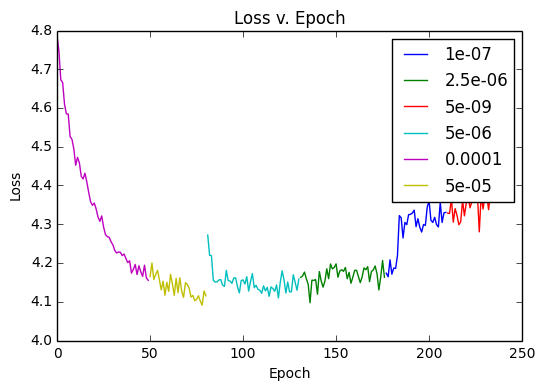

In [105]:
with open('logs/log_series_2_layer.json', 'r') as f:
    logs = json.loads(f.read())
for k in logs.keys():
    plt.plot(logs[k][0], logs[k][1], label=str(k))
plt.title('Loss v. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Loss Versus Sequence Length

We can examine the relationship between loss and sequence length. We can expect higher losses with increasing sequence length as more information must be remembered by the model as it generates, and the model is only trained on examples of sequence length 30 or less. We can generate a scatter plot of batch loss v. sequence length of batch (all batches are same size):

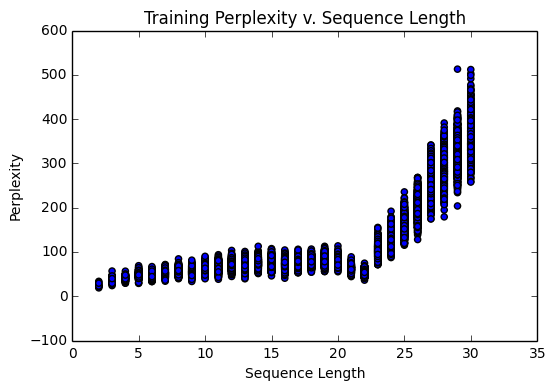

In [106]:
%matplotlib inline
x, y = scatterize_batch_loss(third_report['train_batch_perplexities'])
plt.scatter(x, y)
plt.title('Training Perplexity v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Perplexity')
plt.show()

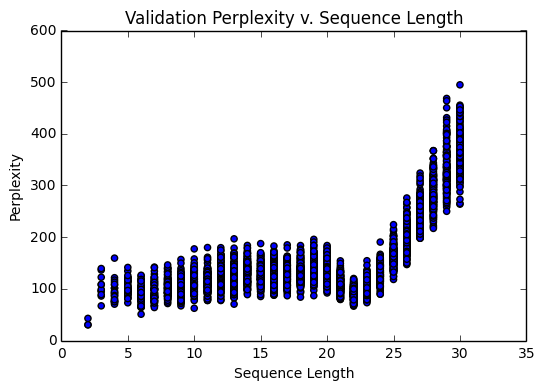

In [107]:
%matplotlib inline
x, y = scatterize_batch_loss(third_report['valid_batch_perplexities'])
plt.scatter(x, y)
plt.title('Validation Perplexity v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Perplexity')
plt.show()

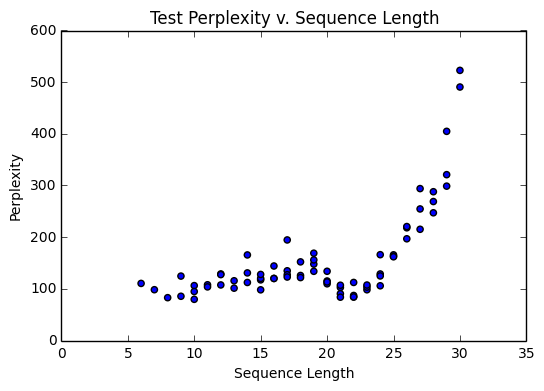

In [108]:
%matplotlib inline
x, y = scatterize_batch_loss(third_report['test_batch_perplexities'])
plt.scatter(x, y)
plt.title('Test Perplexity v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Perplexity')
plt.show()

## Generation Samples

We can also look at examples of how it generates text. Below are side by side comparisons of the labels from the training/validation/test set and the sentence the model generated. A Special `<G>` token will be placed in the generated sequence to illustrate where the model's input ends and it's generation begins.

#### Training Set Generation Examples

In [109]:
for sample in third_report['train_samples']:
    print_sample(sample)
    

Gend:  " I was very lucky , <G> " said <UNK> , who was a <UNK> , and
True: "  I was very lucky , <G> " she said . </S>

Gend:  Before that he ran the homeless charity <UNK> . <G> </S>
True: Before  that he ran the homeless charity <UNK> . <G> </S>

Gend:  The jury <G> was told that the <UNK> was a <UNK> , and
True: The  jury <G> was expected to begin <UNK> later Friday . </S>

Gend:  What <G> 's the <UNK> of the <UNK> <UNK> , which is
True: What  <G> did you think of the Clinton speech ? </S>

Gend:  <UNK> <G> , <UNK> , <UNK> , <UNK> , <UNK> , <UNK>
True: <UNK>  <G> demanded higher wages . </S>

Gend:  GM bought the Hummer brand in 1998 . <G> </S>
True: GM  bought the Hummer brand in 1998 . <G> </S>

Gend:  <UNK> , <G> <UNK> , <UNK> , <UNK> , <UNK> , <UNK> ,
True: <UNK>  , <G> Colo . </S>

Gend:  How are <G> you going to get a <UNK> <UNK> , and you
True: How  are <G> things going ? </S>

Gend:  They will <G> be able to see the <UNK> <UNK> , which is
True: They  will <G> face Virginia T

In [110]:
for sample in third_report['valid_samples'][0:5]:
    print_sample(sample)
    

Gend:  Rick <G> <UNK> , the <UNK> , said the <UNK> was "
True: Rick  <G> <UNK> reports from Windsor , Colo . </S>

Gend:  That left Memphis <G> 's <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
True: That  left Memphis <G> looking for a new coach . </S>

Gend:  Therefore <G> , the <UNK> of the <UNK> <UNK> is a <UNK>
True: Therefore  <G> , I voted against it . </S>

Gend:  <UNK> . <G> </S>
True: <UNK>  . <G> </S>

Gend:  But in <G> the past , the <UNK> <UNK> has been <UNK> by
True: But  in <G> this case they were not <UNK> to . </S>



In [111]:
for sample in third_report['test_samples'][0:5]:
    print_sample(sample)
    

Gend:  " The ' Yes <G> ' is a <UNK> , but it 's a <UNK>
True: "  The ' Yes <G> on <UNK> . </S>

Gend:  Tuesday was <G> the first time the <UNK> <UNK> was <UNK> by the
True: Tuesday  was <G> about <UNK> celebratory dances . </S>

Gend:  Two <G> of the <UNK> were <UNK> , <UNK> , <UNK> ,
True: Two  <G> others sustained broken bones . </S>

Gend:  Luxembourg 's airline <UNK> <UNK> the turnaround <G> in the first quarter of 2008 , while the dollar
True: Luxembourg  's airline <UNK> <UNK> the turnaround <G> . </S>

Gend:  Unfortunately , these incidents were planned . <G> </S>
True: Unfortunately  , these incidents were planned . <G> </S>



### Conclusion

While we can see this model has the expected distribution of losses over each set, and does not over fit, it doesn't generate coherent conclusions to the input sentence fragments. In terms of generation quality, it leaves a lot to be desired.